**<center><font size = "5">Create custom NER model<center>**
***


In [1]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!python -m spacy download en_core_web_lg

2023-04-12 02:19:39.449846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 02:19:40.951776: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
from __future__ import unicode_literals, print_function

import pandas as pd
import os, time

from pathlib import Path
from tqdm import tqdm 
from spacy.training import Example
from spacy import displacy
import spacy
import base64

### NER pipeline

In [4]:
nlpSpacy = spacy.load("en_core_web_lg")
 
print(nlpSpacy.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [5]:
file = open('sampletext.txt')
text = file.read()
file.close()
doc = nlpSpacy(text)
displacy.render(doc, style="ent", jupyter=True)

In [6]:
for entity in doc.ents:
  print(f"Name of the entity {entity.text} type is {entity.label_}")

Name of the entity Electric type is ORG
Name of the entity Tesla type is ORG
Name of the entity Super Bowl type is EVENT
Name of the entity Sunday type is DATE
Name of the entity Autopilot type is ORG
Name of the entity Tesla type is ORG
Name of the entity Model S type is PRODUCT
Name of the entity Tesla type is ORG
Name of the entity Palo Alto type is GPE
Name of the entity California type is GPE
Name of the entity October 14, 2015 type is DATE
Name of the entity Tesla type is ORG
Name of the entity DOJ type is ORG
Name of the entity Autopilot type is ORG
Name of the entity Washington type is GPE
Name of the entity DC type is GPE
Name of the entity Austin type is GPE
Name of the entity Tallahassee type is GPE
Name of the entity Albany type is GPE
Name of the entity Atlanta type is GPE
Name of the entity Sacramento type is GPE
Name of the entity Tesla type is ORG
Name of the entity multimillion dollar type is MONEY
Name of the entity The Dawn Project type is ORG
Name of the entity Dan 

## Annotate the text for NER 

Navigate to 

https://tecoholic.github.io/ner-annotator/

and make all the custom NER and annotate the entities on the text one by one

## Make a Spacy custom NER MODEL

In [7]:
import json
 
with open('annotations.json', 'r') as f:
    data = json.load(f)
    
print(data['annotations'][0])

['Electric carmaker Tesla will face a hit on Super Bowl Sunday, when an ad will play showing the alleged dangers of its Full Self-Driving technology.', {'entities': [[0, 17, 'SUPPLIER'], [18, 23, 'ORG'], [43, 53, 'EVENT'], [54, 60, 'DAY'], [123, 135, 'FEATURE']]}]


In [8]:
data['classes']

['ORG',
 'PRODUCT',
 'MONEY',
 'TECHNOLOGY',
 'EVENT',
 'DAY',
 'LOCATION',
 'DATE',
 'DEPARTMENT',
 'FEATURE',
 'PERSON',
 'ROLE',
 'OBJECT',
 'PROJECT',
 'NUMBER',
 'CUSTOMERS',
 'BLOGS',
 'SUPPLIER']

## Create empty model

In [ ]:
training_data = data.copy()
training_data['classes'] = data['classes']
training_data['annotations'] = []
for text, annotation in data['annotations']:
    try:
        if text!="" and len(annotation['entities']) > 0:
            temp_dict = {}
            temp_dict['text'] = text
            temp_dict['entities'] = []
            for ent in annotation['entities']:
                start = ent[0]
                end = ent[1]
                label = ent[2].upper()
                temp_dict['entities'].append((start, end, label))
        training_data['annotations'].append(temp_dict)
    except:
        pass
print(training_data)

{'classes': ['ORG', 'PRODUCT', 'MONEY', 'TECHNOLOGY', 'EVENT', 'DAY', 'LOCATION', 'DATE', 'DEPARTMENT', 'FEATURE', 'PERSON', 'ROLE', 'OBJECT', 'PROJECT', 'NUMBER', 'CUSTOMERS', 'BLOGS', 'SUPPLIER'], 'annotations': [{'text': 'Electric carmaker Tesla will face a hit on Super Bowl Sunday, when an ad will play showing the alleged dangers of its Full Self-Driving technology.', 'entities': [(0, 17, 'SUPPLIER'), (18, 23, 'ORG'), (43, 53, 'EVENT'), (54, 60, 'DAY'), (123, 135, 'FEATURE')]}, {'text': 'The Autopilot features demonstrated in a Tesla Model S during a Tesla event in Palo Alto, California October 14, 2015. ', 'entities': [(4, 13, 'FEATURE'), (41, 46, 'ORG'), (47, 54, 'PRODUCT'), (64, 69, 'ORG'), (79, 88, 'LOCATION'), (90, 100, 'LOCATION'), (101, 117, 'DATE')]}, {'text': "Tesla confirms DOJ has requested documents on Autopilot, 'Full Self-Driving'", 'entities': [(0, 5, 'ORG'), (15, 18, 'DEPARTMENT'), (46, 55, 'FEATURE'), (57, 75, 'FEATURE')]}, {'text': 'The commercial, which will be a

### Configuration variables

In [ ]:
modelSpacy = None
n_iter=100

### Load the model

In [ ]:
if modelSpacy is not None:
    nlp = spacy.load(modelSpacy)  
    print("Loaded model '%s'" % modelSpacy)
else:
    nlp = spacy.blank('en')  
    print("Created blank 'en' model")

Created blank 'en' model


### Set up pipeline

In [ ]:
if 'ner' not in nlp.pipe_names:
    ner = nlp.add_pipe('ner')
else:
    ner = nlp.get_pipe('ner')

### Train the NER model

In [ ]:
#getting all the entities
for annotations in training_data["annotations"]:
    for ent in annotations['entities']:
        ner.add_label(ent[2])
        
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp.begin_training()
    for itn in range(n_iter):
        losses = {}
        for text, annotations in tqdm(data["annotations"]):
            try:
                if text!="":
                    example = Example.from_dict(nlp.make_doc(text), annotations)
                    #Update the model
                    nlp.update(
                        [example],  
                        drop=0.5,  
                        sgd=optimizer,
                        losses=losses)
            except:
                pass
        print(losses)


 80%|████████  | 20/25 [00:00<00:00, 19.23it/s]/usr/local/lib/python3.8/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "On December 31, Musk replied to a tweet by @WholeM..." with entities "[[3, 14, 'DATE'], [16, 20, 'PERSON'], [44, 57, 'BL...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
100%|██████████| 25/25 [00:01<00:00, 19.85it/s]


{'ner': 748.4617953865836}


100%|██████████| 25/25 [00:01<00:00, 17.51it/s]


{'ner': 295.5354982531711}


100%|██████████| 25/25 [00:01<00:00, 19.32it/s]


{'ner': 276.219936227375}


100%|██████████| 25/25 [00:00<00:00, 25.96it/s]


{'ner': 254.6758886459678}


100%|██████████| 25/25 [00:00<00:00, 27.04it/s]


{'ner': 290.75711990978016}


100%|██████████| 25/25 [00:00<00:00, 25.91it/s]


{'ner': 227.48829230972888}


100%|██████████| 25/25 [00:00<00:00, 27.14it/s]


{'ner': 230.04325941953442}


100%|██████████| 25/25 [00:00<00:00, 25.61it/s]


{'ner': 236.4903372984402}


100%|██████████| 25/25 [00:00<00:00, 27.21it/s]


{'ner': 215.66293260127426}


100%|██████████| 25/25 [00:00<00:00, 26.14it/s]


{'ner': 220.82507084895417}


100%|██████████| 25/25 [00:00<00:00, 26.53it/s]


{'ner': 209.6194882925077}


100%|██████████| 25/25 [00:00<00:00, 26.25it/s]


{'ner': 199.7653460741328}


100%|██████████| 25/25 [00:00<00:00, 26.34it/s]


{'ner': 213.5018476710399}


100%|██████████| 25/25 [00:01<00:00, 18.52it/s]


{'ner': 203.07543132857109}


100%|██████████| 25/25 [00:01<00:00, 17.89it/s]


{'ner': 221.4873628444826}


100%|██████████| 25/25 [00:01<00:00, 22.97it/s]


{'ner': 210.0257306688189}


100%|██████████| 25/25 [00:00<00:00, 26.04it/s]


{'ner': 196.34271177628284}


100%|██████████| 25/25 [00:00<00:00, 25.83it/s]


{'ner': 189.43689078876375}


100%|██████████| 25/25 [00:00<00:00, 27.03it/s]


{'ner': 196.69654884490552}


100%|██████████| 25/25 [00:00<00:00, 26.17it/s]


{'ner': 210.56067387696152}


100%|██████████| 25/25 [00:00<00:00, 27.43it/s]


{'ner': 181.4064514204245}


100%|██████████| 25/25 [00:00<00:00, 26.55it/s]


{'ner': 167.7858475694419}


100%|██████████| 25/25 [00:00<00:00, 26.18it/s]


{'ner': 171.40302146127684}


100%|██████████| 25/25 [00:00<00:00, 26.35it/s]


{'ner': 205.880364754025}


100%|██████████| 25/25 [00:00<00:00, 26.52it/s]


{'ner': 162.44772163482813}


100%|██████████| 25/25 [00:01<00:00, 22.74it/s]


{'ner': 184.349373530244}


100%|██████████| 25/25 [00:01<00:00, 18.16it/s]


{'ner': 165.72889799107642}


100%|██████████| 25/25 [00:01<00:00, 17.87it/s]


{'ner': 148.17040467299324}


100%|██████████| 25/25 [00:00<00:00, 26.93it/s]


{'ner': 183.70820573867584}


100%|██████████| 25/25 [00:00<00:00, 26.56it/s]


{'ner': 175.8970582360657}


100%|██████████| 25/25 [00:00<00:00, 26.71it/s]


{'ner': 194.53793988806507}


100%|██████████| 25/25 [00:00<00:00, 25.60it/s]


{'ner': 204.6579812340621}


100%|██████████| 25/25 [00:00<00:00, 26.89it/s]


{'ner': 131.9276519289242}


100%|██████████| 25/25 [00:00<00:00, 26.15it/s]


{'ner': 170.5381959736376}


100%|██████████| 25/25 [00:00<00:00, 26.64it/s]


{'ner': 163.329497571991}


100%|██████████| 25/25 [00:00<00:00, 26.09it/s]


{'ner': 140.81443263557742}


100%|██████████| 25/25 [00:00<00:00, 26.97it/s]


{'ner': 130.48414428250084}


100%|██████████| 25/25 [00:00<00:00, 26.00it/s]


{'ner': 124.0642152491898}


100%|██████████| 25/25 [00:01<00:00, 19.98it/s]


{'ner': 120.24457663628608}


100%|██████████| 25/25 [00:01<00:00, 16.94it/s]


{'ner': 119.20747507676313}


100%|██████████| 25/25 [00:01<00:00, 20.94it/s]


{'ner': 132.75761403059818}


100%|██████████| 25/25 [00:01<00:00, 24.84it/s]


{'ner': 143.4504506339367}


100%|██████████| 25/25 [00:00<00:00, 25.71it/s]


{'ner': 144.53147978878675}


100%|██████████| 25/25 [00:00<00:00, 26.37it/s]


{'ner': 107.07568383302973}


100%|██████████| 25/25 [00:00<00:00, 26.55it/s]


{'ner': 115.00102487710323}


100%|██████████| 25/25 [00:00<00:00, 26.54it/s]


{'ner': 131.69571948372229}


100%|██████████| 25/25 [00:00<00:00, 26.39it/s]


{'ner': 140.098211457698}


100%|██████████| 25/25 [00:00<00:00, 25.90it/s]


{'ner': 106.27626000547103}


100%|██████████| 25/25 [00:00<00:00, 26.38it/s]


{'ner': 109.69660262030654}


100%|██████████| 25/25 [00:00<00:00, 26.44it/s]


{'ner': 100.96991943410225}


100%|██████████| 25/25 [00:00<00:00, 25.97it/s]


{'ner': 116.84049077383524}


100%|██████████| 25/25 [00:01<00:00, 17.90it/s]


{'ner': 137.84617577510744}


100%|██████████| 25/25 [00:01<00:00, 17.47it/s]


{'ner': 111.35589389784579}


100%|██████████| 25/25 [00:00<00:00, 25.62it/s]


{'ner': 96.9012030959204}


100%|██████████| 25/25 [00:00<00:00, 25.75it/s]


{'ner': 101.61122999578954}


100%|██████████| 25/25 [00:00<00:00, 26.43it/s]


{'ner': 140.87886136086453}


100%|██████████| 25/25 [00:00<00:00, 25.27it/s]


{'ner': 128.7502758077796}


100%|██████████| 25/25 [00:00<00:00, 26.07it/s]


{'ner': 104.70618897997515}


100%|██████████| 25/25 [00:00<00:00, 27.11it/s]


{'ner': 105.10660676420456}


100%|██████████| 25/25 [00:00<00:00, 25.76it/s]


{'ner': 83.46770693323508}


100%|██████████| 25/25 [00:00<00:00, 26.42it/s]


{'ner': 77.83148853867121}


100%|██████████| 25/25 [00:01<00:00, 23.96it/s]


{'ner': 86.9477299718239}


100%|██████████| 25/25 [00:00<00:00, 26.15it/s]


{'ner': 106.38475004122571}


100%|██████████| 25/25 [00:01<00:00, 19.01it/s]


{'ner': 91.34603008718986}


100%|██████████| 25/25 [00:01<00:00, 16.96it/s]


{'ner': 94.53451296860365}


100%|██████████| 25/25 [00:01<00:00, 21.72it/s]


{'ner': 98.97622944613329}


100%|██████████| 25/25 [00:00<00:00, 25.59it/s]


{'ner': 75.50563742258412}


100%|██████████| 25/25 [00:00<00:00, 26.84it/s]


{'ner': 80.92290478465307}


100%|██████████| 25/25 [00:00<00:00, 26.10it/s]


{'ner': 85.80531138515774}


100%|██████████| 25/25 [00:00<00:00, 26.45it/s]


{'ner': 77.90757617392256}


100%|██████████| 25/25 [00:00<00:00, 25.76it/s]


{'ner': 97.65459656756312}


100%|██████████| 25/25 [00:00<00:00, 26.50it/s]


{'ner': 84.1426615833286}


100%|██████████| 25/25 [00:00<00:00, 25.60it/s]


{'ner': 84.82280675814505}


100%|██████████| 25/25 [00:00<00:00, 26.16it/s]


{'ner': 85.10677967967452}


100%|██████████| 25/25 [00:00<00:00, 26.08it/s]


{'ner': 70.51353634915854}


100%|██████████| 25/25 [00:01<00:00, 22.58it/s]


{'ner': 59.2100855173632}


100%|██████████| 25/25 [00:01<00:00, 17.12it/s]


{'ner': 91.02937921234323}


100%|██████████| 25/25 [00:01<00:00, 18.34it/s]


{'ner': 64.99044893658254}


100%|██████████| 25/25 [00:00<00:00, 26.41it/s]


{'ner': 63.47271730007837}


100%|██████████| 25/25 [00:00<00:00, 26.56it/s]


{'ner': 71.00780687030141}


100%|██████████| 25/25 [00:00<00:00, 26.22it/s]


{'ner': 58.30531304523572}


100%|██████████| 25/25 [00:00<00:00, 25.93it/s]


{'ner': 57.6053961959631}


100%|██████████| 25/25 [00:00<00:00, 25.17it/s]


{'ner': 74.45103866132258}


100%|██████████| 25/25 [00:00<00:00, 26.21it/s]


{'ner': 54.22775365158326}


100%|██████████| 25/25 [00:00<00:00, 25.91it/s]


{'ner': 56.8708003373803}


100%|██████████| 25/25 [00:00<00:00, 25.96it/s]


{'ner': 64.34052769627421}


100%|██████████| 25/25 [00:00<00:00, 25.51it/s]


{'ner': 73.51520646394404}


100%|██████████| 25/25 [00:00<00:00, 26.44it/s]


{'ner': 78.83168242929669}


100%|██████████| 25/25 [00:01<00:00, 18.22it/s]


{'ner': 54.867912250302325}


100%|██████████| 25/25 [00:01<00:00, 17.27it/s]


{'ner': 63.26570031671061}


100%|██████████| 25/25 [00:01<00:00, 22.70it/s]


{'ner': 68.75163914068843}


100%|██████████| 25/25 [00:00<00:00, 25.67it/s]


{'ner': 67.50204811609842}


100%|██████████| 25/25 [00:00<00:00, 26.26it/s]


{'ner': 64.30260759080613}


100%|██████████| 25/25 [00:00<00:00, 25.66it/s]


{'ner': 56.38713854686439}


100%|██████████| 25/25 [00:00<00:00, 27.05it/s]


{'ner': 70.53448033334185}


100%|██████████| 25/25 [00:00<00:00, 25.99it/s]


{'ner': 69.67390552577537}


100%|██████████| 25/25 [00:00<00:00, 26.62it/s]


{'ner': 58.94006857365791}


100%|██████████| 25/25 [00:00<00:00, 25.69it/s]


{'ner': 59.07130119329136}


100%|██████████| 25/25 [00:00<00:00, 26.05it/s]


{'ner': 49.040806157288465}


100%|██████████| 25/25 [00:00<00:00, 26.20it/s]

{'ner': 53.742256340147144}


### Test the trained model

In [ ]:
for annotations in training_data["annotations"]:
    doc = nlp(annotations['text'])
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
    print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

Entities [('Electric carmaker', 'SUPPLIER'), ('Tesla', 'ORG'), ('Super Bowl', 'EVENT'), ('Sunday', 'DAY'), ('Self-Driving', 'FEATURE')]
Tokens [('Electric', 'SUPPLIER', 3), ('carmaker', 'SUPPLIER', 1), ('Tesla', 'ORG', 3), ('will', '', 2), ('face', '', 2), ('a', '', 2), ('hit', '', 2), ('on', '', 2), ('Super', 'EVENT', 3), ('Bowl', 'EVENT', 1), ('Sunday', 'DAY', 3), (',', '', 2), ('when', '', 2), ('an', '', 2), ('ad', '', 2), ('will', '', 2), ('play', '', 2), ('showing', '', 2), ('the', '', 2), ('alleged', '', 2), ('dangers', '', 2), ('of', '', 2), ('its', '', 2), ('Full', '', 2), ('Self', 'FEATURE', 3), ('-', 'FEATURE', 1), ('Driving', 'FEATURE', 1), ('technology', '', 2), ('.', '', 2)]
Entities [('Autopilot', 'FEATURE'), ('Tesla', 'ORG'), ('Model S', 'PRODUCT'), ('Tesla', 'ORG'), ('Palo Alto', 'LOCATION'), ('California', 'LOCATION'), ('October 14, 2015', 'DATE')]
Tokens [('The', '', 2), ('Autopilot', 'FEATURE', 3), ('features', '', 2), ('demonstrated', '', 2), ('in', '', 2), ('a', ''

### Save the cusom NER model

In [ ]:
output_dir= os.path.abspath(os.getcwd())
nlp.to_disk(output_dir)
print("Saved model to", output_dir) 

Saved model to /content


### Test the saved custom model

In [ ]:
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)
for annotations in training_data["annotations"][3:5]:
    doc = nlp2(annotations['text'])
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
    print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

Loading from /content
Entities [('Washington', 'LOCATION'), ('DC', 'LOCATION'), ('Austin', 'LOCATION'), ('Tallahassee', 'LOCATION'), ('Albany', 'LOCATION'), ('Atlanta', 'LOCATION'), ('Sacramento', 'LOCATION'), ('Tesla', 'ORG'), ('best light.', 'FEATURE'), ('multimillion dollar', 'MONEY'), ('advertising', 'DEPARTMENT'), ('Dawn Project.', 'DEPARTMENT'), ('Dan O’Dowd', 'PERSON'), ('California', 'LOCATION'), ('CEO', 'ROLE'), ('US Senate', 'DEPARTMENT')]
Tokens [('The', '', 2), ('commercial', '', 2), (',', '', 2), ('which', '', 2), ('will', '', 2), ('be', '', 2), ('aired', '', 2), ('in', '', 2), ('Washington', 'LOCATION', 3), (',', '', 2), ('DC', 'LOCATION', 3), (',', '', 2), ('Austin', 'LOCATION', 3), (',', '', 2), ('Tallahassee', 'LOCATION', 3), (',', '', 2), ('Albany', 'LOCATION', 3), (',', '', 2), ('Atlanta', 'LOCATION', 3), ('and', '', 2), ('Sacramento', 'LOCATION', 3), ('does', '', 2), ('not', '', 2), ('paint', '', 2), ('Tesla', 'ORG', 3), ('in', '', 2), ('the', '', 2), ('best', 'FEAT

In [ ]:
file = open('sampletext.txt')
text = file.read()
file.close()
nlp2 = spacy.load(output_dir)
doc = nlp2(text)
displacy.render(doc, style="ent", jupyter=True)

In [1]:
!pip install transformers seqeval[gpu]


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
df = pd.read_csv('Custom_ner.csv')

In [5]:
df

,text,entities
0,Sentence,O
1,Thousands,QUANTITY
2,of,O
3,demonstrators,O
4,have,O
...,...,...
36637,Burma,O
36638,has,O
36639,confirmed,O
36640,additional,O


In [6]:
data = pd.DataFrame([],columns=['sentence','word_labels'])
t = ''
c = ''
for indx,line in df.iterrows():
  t = t + line['text'] + ' '
  c = c + line['entities'] + ','

  if line['text'] == '.':
    data.loc[len(data)] = [t.strip(),c[:-1]]
    t = ''
    c = ''
data.loc[len(data)] = [t.strip(),c[:-1]]

In [7]:
data

,sentence,word_labels
0,Sentence Thousands of demonstrators have march...,"O,QUANTITY,O,O,O,O,O,COUNTRY,O,O,O,ATTACKS,O,C..."
1,""" Families of soldiers killed in the conflict ...","O,O,O,ARMY,ATTACKS,O,O,O,O,O,ORGANISATION,O,O,..."
2,""" "" "" They marched from the Houses of Parliame...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,PERSON,O,O"
3,""" Police put the number of marchers at 10,000 ...","O,ARMY,O,O,O,O,O,O,QUANTITY,O,O,O,O,O,QUANTITY,O"
4,""" The protest comes on the eve of the annual c...","O,O,O,O,O,O,O,O,O,TIME,O,O,COUNTRY,O,O,O,O,O,O..."
...,...,...
1535,""" The agreement gives Peru permanent , duty - ...","O,O,O,O,O,O,O,O,O,QUANTITY,O,O,O,COUNTRY,O,O,O..."
1536,""" "" The pact was initially approved after disc...","O,O,O,TREATY,O,O,O,O,O,O,O,O,O,DAY,O,O,O,O,O,G..."
1537,""" Peru 's Congress this week passed modificati...","O,O,O,O,O,O,O,O,O,ARMY,O,O,O,O,O,O,TREATY,O"
1538,The agreement will take effect on the first of...,"O,O,O,O,O,O,O,O,O,O,O"


In [8]:
label2id = {k: v for v, k in enumerate(df.entities.unique())}
id2label = {v: k for v, k in enumerate(df.entities.unique())}
label2id

{'O': 0,
 'QUANTITY': 1,
 'COUNTRY': 2,
 'ATTACKS': 3,
 'ARMY': 4,
 'ORGANISATION': 5,
 'PERSON': 6,
 'TIME': 7,
 'LOCATION': 8,
 'COMPOUND': 9,
 'DAY': 10,
 'BUILDINGS': 11,
 'EVENT': 12,
 'GOVERNMENT': 13,
 'TREATY': 14,
 'DATE': 15}

In [9]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 3
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [11]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index]
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)

        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]

        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]

        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [12]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (1540, 2)
TRAIN Dataset: (1232, 2)
TEST Dataset: (308, 2)


In [13]:
training_set[0]

{'ids': tensor([  101,  1000,  1000,  2174,  1010,  1996, 18883,  2529,  2916, 16823,
          4402, 23325,  6633,  6683, 12322,  3669,  2855,  2357,  2091,  1996,
          2695,  1010,  2975,  1037,  2309, 15619,  1999,  1996,  3943,  1011,
          2266,  5239,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,  

In [14]:
training_set[0]["ids"]

tensor([  101,  1000,  1000,  2174,  1010,  1996, 18883,  2529,  2916, 16823,
         4402, 23325,  6633,  6683, 12322,  3669,  2855,  2357,  2091,  1996,
         2695,  1010,  2975,  1037,  2309, 15619,  1999,  1996,  3943,  1011,
         2266,  5239,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [15]:
# print the first 30 tokens and corresponding labels
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["ids"][:30]), training_set[0]["targets"][:30]):
  print('{0:10}  {1}'.format(token, id2label[label.item()]))

[CLS]       O
"           O
"           O
however     O
,           O
the         O
sunni       LOCATION
human       O
rights      O
appoint     O
##ee        O
hash        O
##em        O
ash         O
##ib        O
##li        O
quickly     ARMY
turned      O
down        O
the         O
post        O
,           O
leaving     O
a           O
single      O
vacancy     O
in          O
the         O
33          QUANTITY
-           O


In [16]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [17]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased',
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [18]:
ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)
ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)
outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
initial_loss

tensor(2.7136, device='cuda:0', grad_fn=<NllLossBackward0>)

In [19]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 16])

In [20]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)


In [21]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_preds.extend(predictions)
        tr_labels.extend(targets)

        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    return epoch_loss, tr_accuracy
    # print(f"Training loss epoch: {epoch_loss}")
    # print(f"Training accuracy epoch: {tr_accuracy}")

In [22]:
epoch_loss, tr_accuracy = [],[]
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    loss, acc = train(epoch)
    epoch_loss.append(loss)
    tr_accuracy.append(acc)

Training epoch: 1
Training loss per 100 training steps: 2.730445146560669
Training loss per 100 training steps: 0.46466056500921155
Training loss per 100 training steps: 0.30834866819245305
Training loss per 100 training steps: 0.24864770696062186
Training epoch: 2
Training loss per 100 training steps: 0.08911743760108948
Training loss per 100 training steps: 0.11585434511451438
Training loss per 100 training steps: 0.1079927071076424
Training loss per 100 training steps: 0.10208104025461151
Training epoch: 3
Training loss per 100 training steps: 0.0877353847026825
Training loss per 100 training steps: 0.08076708236395723
Training loss per 100 training steps: 0.0778175096921808
Training loss per 100 training steps: 0.07478446749184417


In [23]:
import matplotlib.pyplot as plt


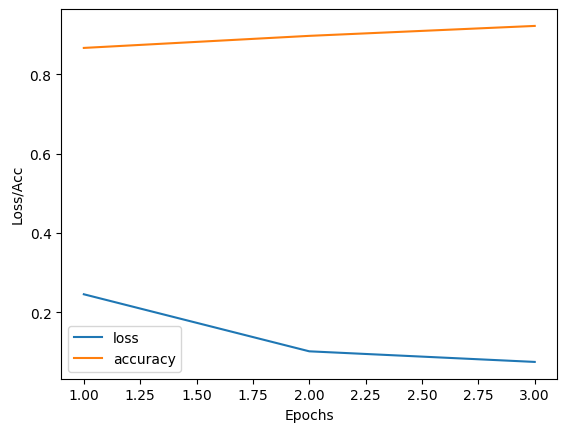

In [39]:
plt.plot(range(1,4),epoch_loss,label='loss')
plt.plot(range(1,4),tr_accuracy,label='accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Acc')
plt.show()

In [24]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(targets)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    #print(eval_labels)
    #print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    #print(labels)
    #print(predictions)

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [25]:
labels, predictions = valid(model, testing_loader)


Validation loss per 100 evaluation steps: 0.15835677087306976
Validation loss per 100 evaluation steps: 0.06882110331207514
Validation Loss: 0.06637264474282985
Validation Accuracy: 0.9321904035232306


In [26]:
df['entities'].unique()

array(['O', 'QUANTITY', 'COUNTRY', 'ATTACKS', 'ARMY', 'ORGANISATION',
       'PERSON', 'TIME', 'LOCATION', 'COMPOUND', 'DAY', 'BUILDINGS',
       'EVENT', 'GOVERNMENT', 'TREATY', 'DATE'], dtype=object)

In [27]:
np.unique(predictions)

array(['ARMY', 'ATTACKS', 'COMPOUND', 'COUNTRY', 'DATE', 'DAY', 'EVENT',
       'GOVERNMENT', 'LOCATION', 'O', 'ORGANISATION', 'PERSON',
       'QUANTITY'], dtype='<U12')

In [28]:
predictions = [' '+i for i in predictions]
labels = [' '+i for i in labels]

In [29]:
from seqeval.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

print(classification_report([labels], [predictions],zero_division=True))

              precision    recall  f1-score   support

        ARMY       0.86      0.58      0.69       121
     ATTACKS       0.72      0.67      0.69        81
   BUILDINGS       1.00      0.00      0.00         5
    COMPOUND       0.76      0.36      0.49        70
     COUNTRY       0.66      0.73      0.69       152
        DATE       0.81      0.65      0.72        20
         DAY       0.75      0.70      0.73       104
       EVENT       1.00      0.14      0.25         7
  GOVERNMENT       1.00      0.17      0.29        24
    LOCATION       0.59      0.37      0.45        54
           O       0.44      0.35      0.39       744
ORGANISATION       0.75      0.13      0.22        23
      PERSON       0.30      0.12      0.17        67
    QUANTITY       0.66      0.78      0.72        88
        TIME       1.00      0.00      0.00         9
      TREATY       1.00      0.00      0.00         3

   micro avg       0.58      0.45      0.51      1572
   macro avg       0.77   

In [30]:
def getNER(sentence):
  inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")

  # move to gpu
  ids = inputs["input_ids"].to(device)
  mask = inputs["attention_mask"].to(device)
  # forward pass
  outputs = model(ids, mask)
  logits = outputs[0]

  active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
  flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

  tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
  token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
  wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

  word_level_predictions = []
  for pair in wp_preds:
    if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
      # skip prediction
      continue
    else:
      word_level_predictions.append(pair[1])

  # we join tokens, if they are not special ones
  str_rep = " ".join([t[0] for t in wp_preds if t[0] not in ['[CLS]', '[SEP]', '[PAD]']]).replace(" ##", "")
  print(str_rep)
  print(word_level_predictions)

In [31]:
sentence = "@HuggingFace is a company based in New York, but is also has employees working in Paris"
getNER(sentence)

@ huggingface is a company based in new york , but is also has employees working in paris
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [32]:
sentence = 'This is trial'
getNER(sentence)

this is trial
['O', 'O', 'O']


In [33]:
sentence = 'Britain'
getNER(sentence)

britain
['O']


In [ ]:
!pip install transformers seqeval[gpu]


import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

df = pd.read_csv('Custom_ner.csv')

df

data = pd.DataFrame([],columns=['sentence','word_labels'])
t = ''
c = ''
for indx,line in df.iterrows():
  t = t + line['text'] + ' '
  c = c + line['entities'] + ','

  if line['text'] == '.':
    data.loc[len(data)] = [t.strip(),c[:-1]]
    t = ''
    c = ''
data.loc[len(data)] = [t.strip(),c[:-1]]

data

label2id = {k: v for v, k in enumerate(df.entities.unique())}
id2label = {v: k for v, k in enumerate(df.entities.unique())}
label2id

MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 3
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index]
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)

        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]

        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]

        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        }

    def __len__(self):
        return self.len

train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

training_set[0]

training_set[0]["ids"]

# print the first 30 tokens and corresponding labels
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["ids"][:30]), training_set[0]["targets"][:30]):
  print('{0:10}  {1}'.format(token, id2label[label.item()]))

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

model = BertForTokenClassification.from_pretrained('bert-base-uncased',
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)
ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)
outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
initial_loss

tr_logits = outputs[1]
tr_logits.shape

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)


# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_preds.extend(predictions)
        tr_labels.extend(targets)

        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    return epoch_loss, tr_accuracy
    # print(f"Training loss epoch: {epoch_loss}")
    # print(f"Training accuracy epoch: {tr_accuracy}")

epoch_loss, tr_accuracy = [],[]
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    loss, acc = train(epoch)
    epoch_loss.append(loss)
    tr_accuracy.append(acc)

import matplotlib.pyplot as plt


plt.plot(range(1,4),epoch_loss,label='loss')
plt.plot(range(1,4),tr_accuracy,label='accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Acc')
plt.show()

def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(targets)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    #print(eval_labels)
    #print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    #print(labels)
    #print(predictions)

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

labels, predictions = valid(model, testing_loader)


df['entities'].unique()

np.unique(predictions)

predictions = [' '+i for i in predictions]
labels = [' '+i for i in labels]

from seqeval.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

print(classification_report([labels], [predictions],zero_division=True))

def getNER(sentence):
  inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")

  # move to gpu
  ids = inputs["input_ids"].to(device)
  mask = inputs["attention_mask"].to(device)
  # forward pass
  outputs = model(ids, mask)
  logits = outputs[0]

  active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
  flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

  tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
  token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
  wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

  word_level_predictions = []
  for pair in wp_preds:
    if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
      # skip prediction
      continue
    else:
      word_level_predictions.append(pair[1])

  # we join tokens, if they are not special ones
  str_rep = " ".join([t[0] for t in wp_preds if t[0] not in ['[CLS]', '[SEP]', '[PAD]']]).replace(" ##", "")
  print(str_rep)
  print(word_level_predictions)

sentence = "@HuggingFace is a company based in New York, but is also has employees working in Paris"
getNER(sentence)

sentence = 'This is trial'
getNER(sentence)

sentence = 'Britain'
getNER(sentence)

